In [3]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/fa1t_38_run_1'
data_files = '/mnt/tess/astronet/tfrecords-38-test/*'
tces_file = '/mnt/tess/astronet/tces-v14-test.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/fa1t_38_run_1/1/AstroCNNModel_final_alpha_1_tuned_20220519_153609',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/2/AstroCNNModel_final_alpha_1_tuned_20220519_161708',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/3/AstroCNNModel_final_alpha_1_tuned_20220519_165750',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/4/AstroCNNModel_final_alpha_1_tuned_20220519_173827',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/5/AstroCNNModel_final_alpha_1_tuned_20220519_181858',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/6/AstroCNNModel_final_alpha_1_tuned_20220519_185933',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/7/AstroCNNModel_final_alpha_1_tuned_20220519_194021',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/8/AstroCNNModel_final_alpha_1_tuned_20220519_202120',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/9/AstroCNNModel_final_alpha_1_tuned_20220519_210211',
 '/mnt/tess/astronet/checkpoints/fa1t_38_run_1/10/AstroCNNModel_final_alpha_1_tuned_2022051

In [4]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('astro_id'))
    print()

Running model 1
2516 records
Running model 2
2516 records
Running model 3
2516 records
Running model 4
2516 records
Running model 5
2516 records
Running model 6
2516 records
Running model 7
2516 records
Running model 8
2516 records
Running model 9
2516 records
Running model 10
2516 records


In [32]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.215

In [33]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for ex_id in preds.index:
        if ex_id not in agg_preds:
            agg_preds[ex_id] = []

        row = preds[preds.index == ex_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {ex_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[ex_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[ex_id].append(preds.columns[np.argmax(masked_v)])

In [34]:
final_preds = []
for ex_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[ex_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'astro_id': ex_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('astro_id')

In [35]:
tce_table = pd.read_csv(tces_file, header=0, low_memory=False)
tce_table['astro_id'] = tce_table['Astro ID']
tce_table = tce_table.set_index('astro_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels + ['TIC ID']]

pl = final_preds.join(tce_labels, on='astro_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [36]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.972
Precision: 0.7570093457943925


In [37]:
for i in pl[pos & pneg]['TIC ID']:
    print(i)

116252237
117789567
129012152
105020452
31265416
384074629
69549569


In [38]:
for i in pl[neg & ppos]['TIC ID']:
    print(i)

198883710
267346717
91329106
354129146
14739172
431991565
372711165
317347811
136756300
142746471
316627165
41680093
445605526
459221499
27843322
50354055
408093233
64905065
123982605
129115637
17059855
277535606
369643357
38586438
40457215
418013928
256003229
468716176
240403806
395084760
164410859
29171191
192875463
28177695
136466789
404850274
456564311
466657734
21683845
277108565
112988537
404933760
365608020
340206201
466227976
294923253
278415116
337350767
31694643
269857938
29984231
419736622
426032062
387067244
86259225
318608749
382254048
404559668
355363175
310420324
373779556
290304391
380394964
350146296
280868770
404006437
295372879
409747080
231744905
183306212
229810745
372203477
279161482
129333155
28168394
403625251
116575240
374615768


In [39]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

# compare(ensemble_preds, preds.index == pl[pl['TIC ID'] == 28484801].index.values[0])

In [40]:
# pl[pl.index == pl[pl['TIC ID'] == 1254504863].index.values[0]]

### PR curve

In [41]:
ids = set(ensemble_preds[0].index.values)

index = {v: i for i, v in enumerate(ids)}

pred_es = np.zeros([len(ensemble_preds), len(index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        ex_id, pred_e = row[0], row[1][col_e]
        pred_es[i][index[ex_id]] = pred_e

lbl_es = np.zeros([len(index)], dtype=np.bool)
for row in tce_labels.iterrows():
    ex_id, lbl_e = row[0], row[1]['disp_e']
    lbl_es[index[ex_id]] = (lbl_e > 0)

In [42]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9647226636251953, max R: 1.0, max P: 1.0
100% recall at: 15%, threshold: 0.0004930858612606256


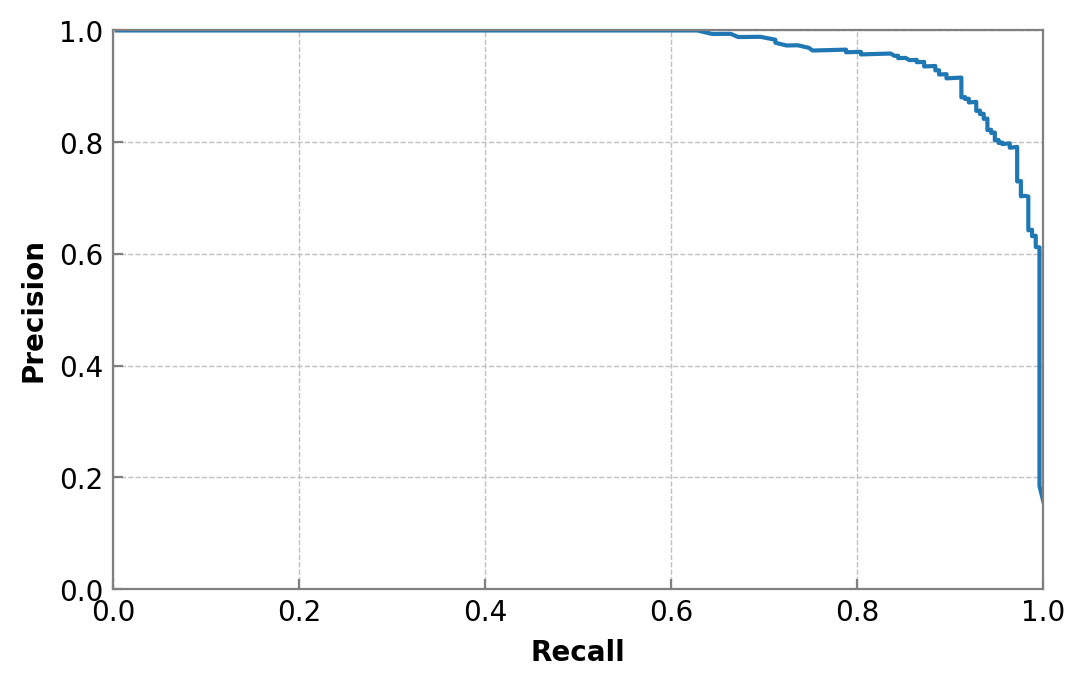

In [43]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)